In [1]:
from collections import namedtuple
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, fbeta_score, make_scorer

import presentation as p

# reading in relevant data frames

training_df_scaled_enc_le_clean = pd.read_csv('data/training_df_scaled_enc_le_clean.csv', index_col=None)
#training_df_enc_le_clean = pd.read_csv('data/training_df_enc_le_clean.csv', index_col=None)
training_df_scaled_enc_le_clean = pd.read_csv('data/training_df_scaled_enc_le_clean.csv', index_col=None)
testing_df_scaled_enc_le_clean = pd.read_csv('data/testing_df_scaled_enc_le_clean.csv', index_col=None)
#testing_df_enc_le_clean = pd.read_csv('data/testing_df_enc_le_clean.csv', index_col=None)
testing_df_scaled_enc_le_clean = pd.read_csv('data/testing_df_scaled_enc_le_clean.csv', index_col=None)

X_train_is_attack = training_df_scaled_enc_le_clean.drop(['target', 'target_group', 'is_attack'], axis=1)
X_train_attack_group = training_df_scaled_enc_le_clean[training_df_scaled_enc_le_clean.is_attack].drop(['target', 'target_group', 'is_attack'], axis=1)
y_train_is_attack = training_df_scaled_enc_le_clean.is_attack
y_train_attack_group = training_df_scaled_enc_le_clean[training_df_scaled_enc_le_clean.is_attack].target_group
X_test_is_attack = testing_df_scaled_enc_le_clean.drop(['target', 'target_group', 'is_attack'], axis=1)
X_test_attack_group = testing_df_scaled_enc_le_clean[testing_df_scaled_enc_le_clean.is_attack].drop(['target', 'target_group', 'is_attack'], axis=1)
y_true_is_attack = testing_df_scaled_enc_le_clean.is_attack
y_true_attack_group = testing_df_scaled_enc_le_clean[testing_df_scaled_enc_le_clean.is_attack].target_group

def simple_confusion_matrix(y_true, y_pred, target):
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap=p.Colors.blues_c)
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap=p.Colors.purples_c)
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

eval_result = namedtuple('HyperparameterTuningResult', ['model', 'accuracy', 'fbeta'])

def evaluate_model(model, X_test, y_true, beta, average):
    pred = model.predict(X_test)
    acc = accuracy_score(y_true, pred)
    fbeta = fbeta_score(y_true, pred, beta=beta, average=average)
    print('-- Training Results --')
    print(f'Best Parameters:\n{param_string}', end='')
    print(f'Best Score:\n\t{best_score:.6f}')
    print('\n-- Testing Results --')
    print(f'Accuracy    on Verification Data:\t{acc:.6f}')
    print(f'Fbeta scroe on Verification Data:\t{fbeta:.6f}\n')
    print(classification_report(y_true, pred))
    return eval_result(model, acc, fbeta)

In [2]:
# Transform target values for categorical classification for the second model

y_train_attack_group_enc = pd.get_dummies(y_train_attack_group, prefix='class')
y_true_attack_group_enc = pd.get_dummies(y_true_attack_group, prefix='class')

--------------------------------------------------------------------------------

# Neural Network

In [28]:
# Attack Detection

metrics = tf.keras.metrics.FBetaScore(beta=100., threshold=.5, average='macro')
nn_model_is_attack = Sequential([
    Input(
        shape=(X_train_is_attack.shape[1],),
        batch_size=64
    ),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    #Dense(16, activation='relu'),
    Dropout(.5),
    Dense(1, activation='sigmoid'),
])
nn_model_is_attack.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[metrics, tf.keras.metrics.Accuracy()]
)

In [29]:
history_is_attack = nn_model_is_attack.fit(
    X_train_is_attack,
    y_train_is_attack,
    epochs=10,
    validation_split=.3,
    verbose=2
)

Epoch 1/10
23516/23516 - 13s - 548us/step - accuracy: 0.0457 - fbeta_score: 0.9670 - loss: 0.0182 - val_accuracy: 0.4066 - val_fbeta_score: 0.9960 - val_loss: 0.0158
Epoch 2/10
23516/23516 - 12s - 515us/step - accuracy: 0.0793 - fbeta_score: 0.9838 - loss: 0.0096 - val_accuracy: 0.4280 - val_fbeta_score: 0.9930 - val_loss: 0.0190
Epoch 3/10
23516/23516 - 12s - 515us/step - accuracy: 0.0833 - fbeta_score: 0.9867 - loss: 0.0066 - val_accuracy: 0.4329 - val_fbeta_score: 0.9793 - val_loss: 0.0577
Epoch 4/10
23516/23516 - 12s - 514us/step - accuracy: 0.0880 - fbeta_score: 0.9882 - loss: 0.0059 - val_accuracy: 0.4546 - val_fbeta_score: 0.9973 - val_loss: 0.0182
Epoch 5/10
23516/23516 - 12s - 513us/step - accuracy: 0.0947 - fbeta_score: 0.9893 - loss: 0.0100 - val_accuracy: 0.4340 - val_fbeta_score: 0.8599 - val_loss: 0.1580
Epoch 6/10
23516/23516 - 12s - 512us/step - accuracy: 0.0927 - fbeta_score: 0.9904 - loss: 0.0055 - val_accuracy: 0.5453 - val_fbeta_score: 0.9972 - val_loss: 0.0206
Epoc

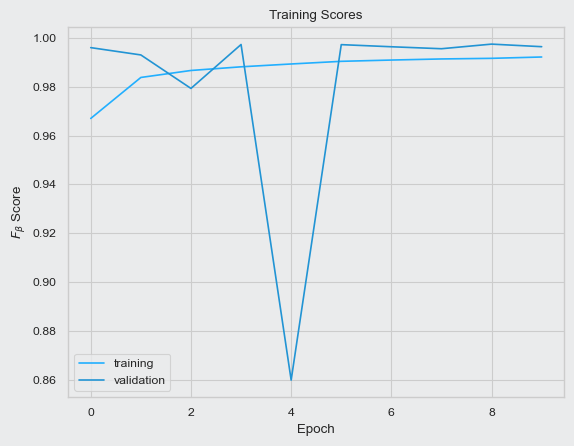

In [30]:
# Visualize Learning History

sns.lineplot(history_is_attack.history['fbeta_score'], label='training')
sns.lineplot(history_is_attack.history['val_fbeta_score'], label='validation')
plt.title('Training Scores')
plt.xlabel('Epoch')
plt.ylabel(r'$F_\beta$ Score')
plt.show()

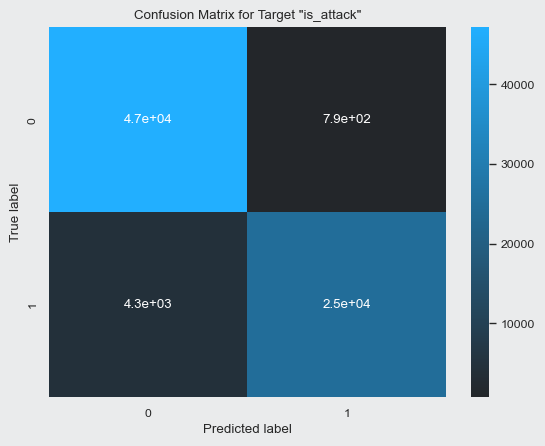

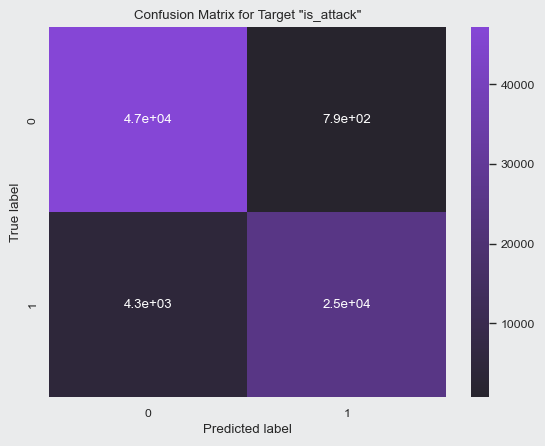

In [31]:
# Evaluation

y_pred_is_attack = nn_model_is_attack.predict(X_test_is_attack, verbose=0)
y_pred_is_attack_labels = (y_pred_is_attack > .5).astype(int).flatten()
simple_confusion_matrix(y_true_is_attack, y_pred_is_attack_labels, 'is_attack')

In [34]:
from sklearn.metrics import confusion_matrix
total_attacks = y_true_is_attack.value_counts().iloc[1]
confusion = confusion_matrix(y_true_is_attack, y_pred_is_attack_labels)
false_negatives = confusion[1, 0]
print(f'False negatives: {false_negatives} ({100 * false_negatives / total_attacks:.3f}% out of {total_attacks} attacks, {100 * false_negatives / len(y_true_is_attack):.3f}% overall)\n')

False negatives: 4337 (14.763% out of 29378 attacks, 5.611% overall)



In [35]:
nn_model_is_attack.metrics_names

['loss', 'compile_metrics']

In [36]:
nn_model_is_attack.evaluate(X_test_is_attack, y_true_is_attack)

2416/2416 ━━━━━━━━━━━━━━━━━━━━ 1s 305us/step - accuracy: 0.2042 - fbeta_score: 0.7933 - loss: 0.8115


[0.9578710794448853, 0.8523827791213989, 0.27869996428489685]

In [37]:
history_is_attack = nn_model_is_attack.fit(
    X_train_is_attack,
    y_train_is_attack,
    epochs=65,
    validation_split=.3,
    verbose=2
)

Epoch 1/65
23516/23516 - 12s - 510us/step - accuracy: 0.0977 - fbeta_score: 0.9919 - loss: 0.0067 - val_accuracy: 0.4628 - val_fbeta_score: 0.9966 - val_loss: 0.0241
Epoch 2/65
23516/23516 - 12s - 521us/step - accuracy: 0.0975 - fbeta_score: 0.9923 - loss: 0.0051 - val_accuracy: 0.4565 - val_fbeta_score: 0.9912 - val_loss: 0.0362
Epoch 3/65
23516/23516 - 12s - 520us/step - accuracy: 0.0973 - fbeta_score: 0.9923 - loss: 0.0043 - val_accuracy: 0.4528 - val_fbeta_score: 0.9933 - val_loss: 0.0243
Epoch 4/65
23516/23516 - 13s - 541us/step - accuracy: 0.0980 - fbeta_score: 0.9922 - loss: 0.0047 - val_accuracy: 0.5576 - val_fbeta_score: 0.9967 - val_loss: 0.0280
Epoch 5/65
23516/23516 - 12s - 526us/step - accuracy: 0.0977 - fbeta_score: 0.9924 - loss: 0.0076 - val_accuracy: 0.5584 - val_fbeta_score: 0.9968 - val_loss: 0.0279
Epoch 6/65
23516/23516 - 12s - 505us/step - accuracy: 0.0991 - fbeta_score: 0.9924 - loss: 0.0062 - val_accuracy: 0.5595 - val_fbeta_score: 0.9974 - val_loss: 0.0274
Epoc

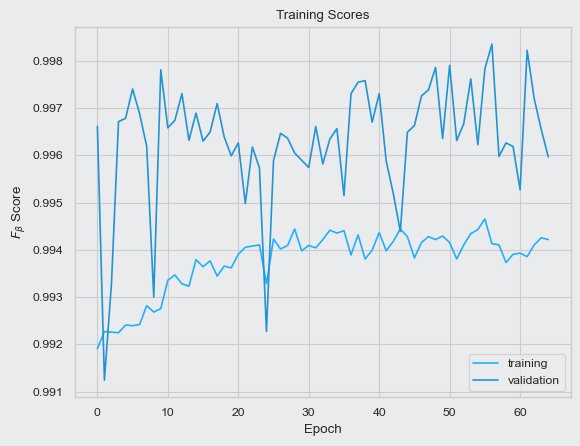

In [38]:
# Visualize Learning History

sns.lineplot(history_is_attack.history['fbeta_score'], label='training')
sns.lineplot(history_is_attack.history['val_fbeta_score'], label='validation')
plt.title('Training Scores')
plt.xlabel('Epoch')
plt.ylabel(r'$F_\beta$ Score')
plt.show()

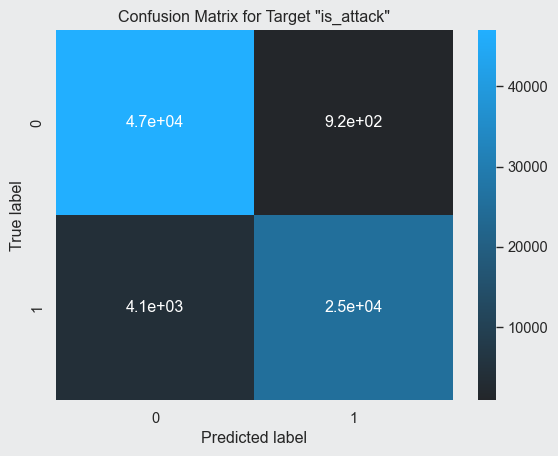

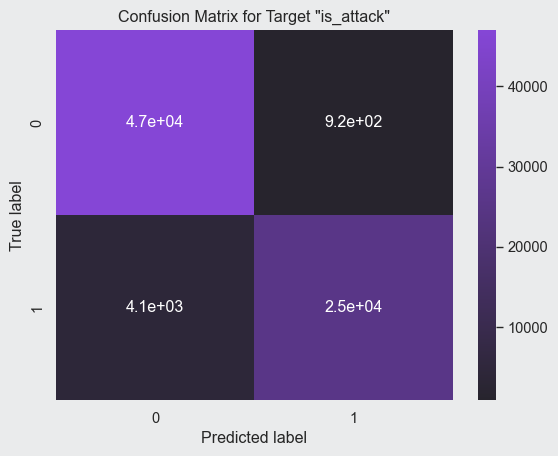

In [6]:
# Evaluation

y_pred_is_attack = nn_model_is_attack.predict(X_test_is_attack, verbose=0)
y_pred_is_attack_labels = (y_pred_is_attack > .5).astype(int).flatten()
simple_confusion_matrix(y_true_is_attack, y_pred_is_attack_labels, 'is_attack')

In [40]:
total_attacks = y_true_is_attack.value_counts().iloc[1]
confusion = confusion_matrix(y_true_is_attack, y_pred_is_attack_labels)
false_negatives = confusion[1, 0]
print(f'False negatives: {false_negatives} ({100 * false_negatives / total_attacks:.3f}% out of {total_attacks} attacks, {100 * false_negatives / len(y_true_is_attack):.3f}% overall)\n')

False negatives: 4121 (14.028% out of 29378 attacks, 5.332% overall)



In [42]:
nn_model_is_attack.evaluate(X_test_is_attack, y_true_is_attack)

2416/2416 ━━━━━━━━━━━━━━━━━━━━ 1s 288us/step - accuracy: 0.2463 - fbeta_score: 0.8106 - loss: 1.6920


[2.3140103816986084, 0.859734296798706, 0.317941278219223]

In [64]:
nn_model_is_attack.get_metrics_result()

{'accuracy': 0.317941278219223,
 'fbeta_score': 0.859734296798706,
 'loss': 2.3140103816986084}

In [65]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true_is_attack, y_pred_is_attack_labels)

0.9347789522712865

In [67]:
from sklearn.metrics import fbeta_score
fbeta_score(y_true_is_attack, y_pred_is_attack_labels, beta=100., average='binary')

0.8597343309089107

--------------------------------------------------------------------------------

In [55]:
# Attack Classification

metrics = tf.keras.metrics.FBetaScore(beta=100., threshold=.5, average=None)
nn_model_attack_group = Sequential([
    Input(
        shape=(X_train_attack_group.shape[1],),
        batch_size=128
    ),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dropout(.5),
    Dense(4, activation='softmax'),
])
nn_model_attack_group.compile(
    loss='categorical_focal_crossentropy',
    optimizer='adam',
    #metrics=['accuracy']
    #metrics=[tf.keras.metrics.F1Score(), tf.keras.metrics.Accuracy()]
    metrics=[metrics, tf.keras.metrics.Accuracy()]
)

In [59]:
### Keep Going Here

history_attack_group = nn_model_attack_group.fit(
    X_train_attack_group,
    y_train_attack_group_enc,
    epochs=200,
    validation_split=.4,
    verbose=2
)

Epoch 1/200
4916/4916 - 3s - 646us/step - accuracy: 0.5640 - fbeta_score: 0.8412 - loss: 6.9655e-04 - val_accuracy: 0.2732 - val_fbeta_score: 0.7297 - val_loss: 1.5390
Epoch 2/200
4916/4916 - 3s - 662us/step - accuracy: 0.3655 - fbeta_score: 0.8611 - loss: 6.7356e-04 - val_accuracy: 0.2788 - val_fbeta_score: 0.7823 - val_loss: 1.5388
Epoch 3/200
4916/4916 - 3s - 619us/step - accuracy: 0.3347 - fbeta_score: 0.8482 - loss: 7.1495e-04 - val_accuracy: 0.1586 - val_fbeta_score: 0.7142 - val_loss: 1.5399
Epoch 4/200
4916/4916 - 3s - 618us/step - accuracy: 0.4375 - fbeta_score: 0.8560 - loss: 6.9040e-04 - val_accuracy: 0.4479 - val_fbeta_score: 0.7821 - val_loss: 1.5383
Epoch 5/200
4916/4916 - 3s - 616us/step - accuracy: 0.6239 - fbeta_score: 0.8936 - loss: 8.9051e-04 - val_accuracy: 0.4262 - val_fbeta_score: 0.7950 - val_loss: 1.5397
Epoch 6/200
4916/4916 - 3s - 628us/step - accuracy: 0.5720 - fbeta_score: 0.8113 - loss: 0.0011 - val_accuracy: 0.4457 - val_fbeta_score: 0.6502 - val_loss: 1.5

/var/folders/yx/bw2wb6890tsb79vs_n2wcbsh0000gn/T/ipykernel_28010/506042475.py:7: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.lineplot(pd.DataFrame([x.numpy() for x in history_attack_group.history[f'val_{score}']]), palette=p.Colors.purples)#, label='validation')


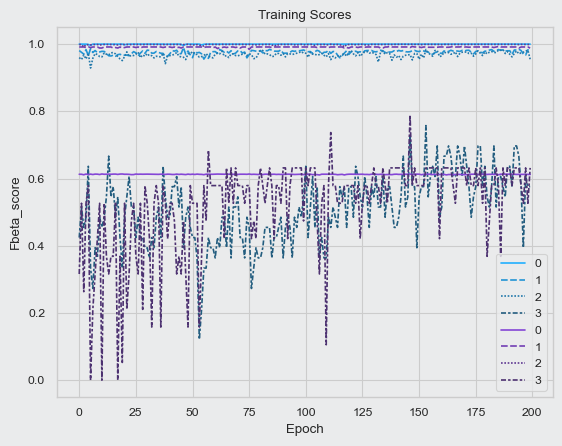

In [60]:
# Visualize Learning History

score = 'fbeta_score'
#sns.lineplot(pd.DataFrame(history_attack_group.history[score]))#, label='training')
#sns.lineplot(pd.DataFrame(history_attack_group.history[f'val_{score}']), palette=p.Colors.purples)#, label='validation')
sns.lineplot(pd.DataFrame([x.numpy() for x in history_attack_group.history[score]]))#, label='training')
sns.lineplot(pd.DataFrame([x.numpy() for x in history_attack_group.history[f'val_{score}']]), palette=p.Colors.purples)#, label='validation')
plt.title('Training Scores')
plt.xlabel('Epoch')
plt.ylabel(score.capitalize())
plt.show()

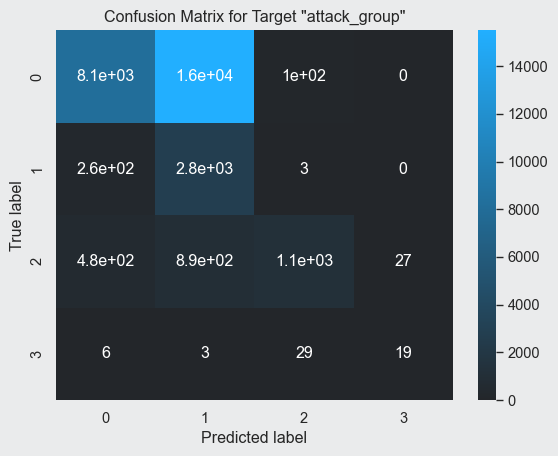

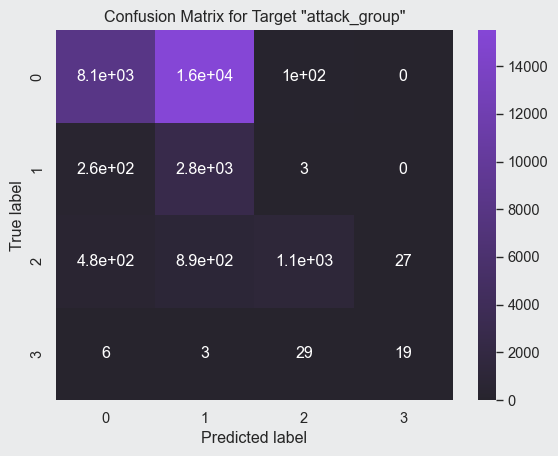

In [4]:
# Evaluation

y_pred_attack_group = nn_model_attack_group.predict(X_test_attack_group, verbose=0)
y_pred_attack_group_labels = np.argmax(y_pred_attack_group, axis=1)
y_true_attack_group_labels = np.argmax(y_true_attack_group_enc, axis=1)
simple_confusion_matrix(y_true_attack_group_labels, y_pred_attack_group_labels, 'attack_group')

In [68]:
accuracy_score(y_true_attack_group_labels, y_pred_attack_group_labels)

0.41112397031792497

In [72]:
fbeta_score(y_true_attack_group_labels,y_pred_attack_group_labels, beta=100., average='macro')

0.5096807591098216

--------------------------------------------------------------------------------

Save both models for re-use or adjustments.

In [125]:
nn_model_is_attack.save('data/network-is_attack-nn.keras')
nn_model_attack_group.save('data/network-attack-group-nn.keras')

Load both models for re-use or adjustments.

In [5]:
nn_model_is_attack = tf.keras.models.load_model('data/network-is_attack-nn.keras')
nn_model_attack_group = tf.keras.models.load_model('data/network-attack-group-nn.keras')